In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pathlib

from collections import Counter
from sklearn.preprocessing import StandardScaler

import keras.backend as K
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping



2023-02-21 07:36:30.517707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 07:36:32.395171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-21 07:36:32.395576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-21 07:36:32.395590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
train_data_dir = pathlib.Path("/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/train")
print(train_data_dir)

test_data_dir = pathlib.Path("/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/test")
print(test_data_dir)

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 16
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10


/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/train
/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/test


In [3]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data3/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')



Found 600 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [7]:
# create model structure
emotion_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
emotion_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

emotion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

In [8]:
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [reduce_learningrate]


emotion_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [9]:
emotion_model_info = emotion_model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//validation_generator.batch_size,
                                epochs=50,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50


/tmp/ipykernel_45647/4152142760.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(generator=train_generator,


1/9 [==>...........................] - ETA: 10s - loss: 1.0996 - accuracy: 0.2083

2023-02-21 07:39:47.733082: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 21196800 exceeds 10% of free system memory.
2023-02-21 07:39:47.733963: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 21196800 exceeds 10% of free system memory.


9/9 [==============================] - 5s 468ms/step - loss: 1.1029 - accuracy: 0.3694 - val_loss: 1.0943 - val_accuracy: 0.3828 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 3s 367ms/step - loss: 1.1032 - accuracy: 0.3209 - val_loss: 1.0974 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 4s 406ms/step - loss: 1.0975 - accuracy: 0.3451 - val_loss: 1.0972 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 1.1001 - accuracy: 0.3316
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
9/9 [==============================] - 4s 392ms/step - loss: 1.1001 - accuracy: 0.3316 - val_loss: 1.0979 - val_accuracy: 0.3359 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 3s 352ms/step - loss: 1.0990 - accuracy: 0.3321 - val_loss: 1.1005 - val_accuracy: 0.3359 - lr: 2.0000e-04
Epoch 6/50
9/9 [==============================] - 3s 328ms/step - loss: 1.0969 - acc

In [10]:
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(emotion_model_info.history) 

# or save to csv: 
hist_csv_file = 'historyCNN_au.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [13]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()



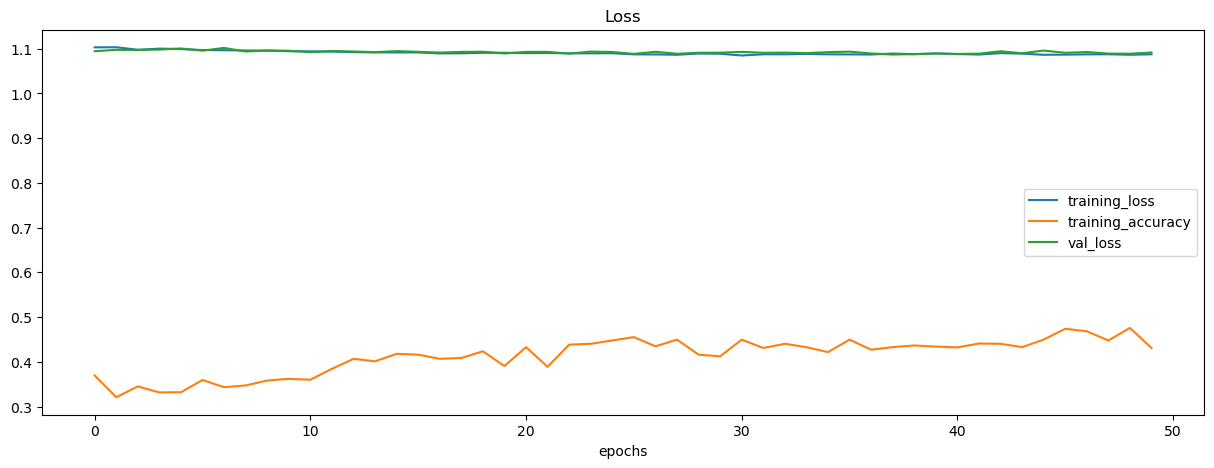

In [14]:
plot_curves(emotion_model_info)